In [2]:
import numpy as np
import pandas as pd

# Random generator
rng = np.random.default_rng(42)
n = 5000  # number of claims

# Create synthetic insurance claims dataset
df = pd.DataFrame({
    "claim_id": np.arange(1, n+1),
    "claim_amount": rng.gamma(shape=2.0, scale=500.0, size=n),   # skewed, € values
    "days_to_file": rng.integers(0, 60, size=n),                 # days after incident
    "channel": rng.choice(["agent", "online", "phone"], size=n, p=[0.5, 0.3, 0.2]),
    "policy_tenure_yrs": rng.uniform(0, 15, size=n),
    "has_prior_claims": rng.integers(0, 2, size=n),
    "region": rng.choice(["NL-North", "NL-West", "NL-South", "NL-East"], size=n),
    "vehicle_age_yrs": rng.uniform(0, 20, size=n),
    "claim_type": rng.choice(["collision", "theft", "weather", "glass"], size=n, p=[0.55, 0.15, 0.2, 0.1])
})

# Fraud risk logic (logit model, intuitive weights)
logit = (
    0.002 * df["claim_amount"] +
    0.06  * df["days_to_file"] +
   -0.15  * df["policy_tenure_yrs"] +
    0.85  * df["has_prior_claims"] +
    (df["channel"].eq("online") * 0.40).astype(int) +
    (df["channel"].eq("phone")  * 0.25).astype(int) +
    (df["claim_type"].eq("theft") * 0.50).astype(int) +
    0.05  * df["vehicle_age_yrs"] +
    (df["region"].eq("NL-West") * 0.10).astype(int)
).astype(float)

# Sigmoid helper
def sigmoid(x): 
    return 1.0 / (1.0 + np.exp(-x))

# Find intercept so fraud rate ~10%
target_rate = 0.10
b_low, b_high = -20.0, 20.0
for _ in range(60):
    b_mid = (b_low + b_high) / 2
    mean_p = sigmoid(logit + b_mid).mean()
    if mean_p > target_rate:
        b_high = b_mid
    else:
        b_low = b_mid
b_intercept = (b_low + b_high) / 2

# Final fraud probabilities
proba = sigmoid(logit + b_intercept)
df["is_fraud"] = (rng.random(n) < proba).astype(int)

# Save dataset
df.to_csv("claims_dataset.csv", index=False)

print("Dataset created and saved as claims_dataset.csv")
print(df.head())
print("\nFraud rate in dataset:", df['is_fraud'].mean())


Dataset created and saved as claims_dataset.csv
   claim_id  claim_amount  days_to_file channel  policy_tenure_yrs  \
0         1   1045.908635            25   phone          12.447009   
1         2   1417.672795             7   phone           3.186573   
2         3    918.607790            12   agent          11.737620   
3         4    822.535211            42  online          12.918786   
4         5   1539.627665            10  online          13.149614   

   has_prior_claims    region  vehicle_age_yrs claim_type  is_fraud  
0                 0  NL-South         9.048557    weather         0  
1                 1  NL-South        14.452712  collision         0  
2                 0   NL-West         9.718711    weather         0  
3                 0  NL-South        13.256328  collision         0  
4                 0  NL-North         5.262198  collision         0  

Fraud rate in dataset: 0.1044


C:\Users\cstam\AppData\Local\Temp\ipykernel_31344\932970422.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="is_fraud", data=df, palette="Set2")


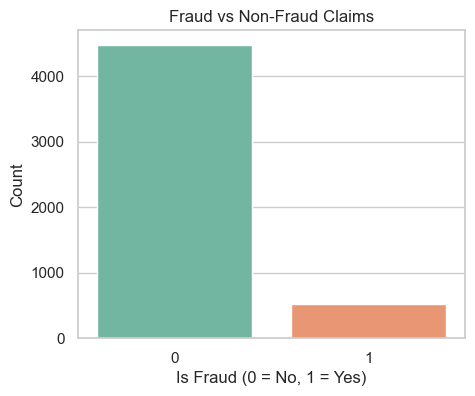

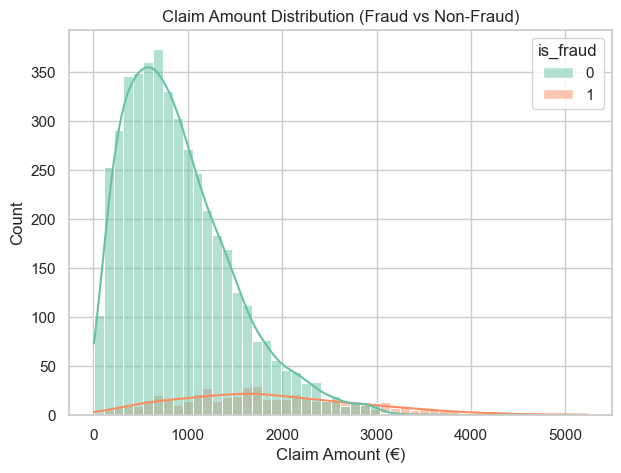

C:\Users\cstam\AppData\Local\Temp\ipykernel_31344\932970422.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="is_fraud", y="days_to_file", data=df, palette="Set2")


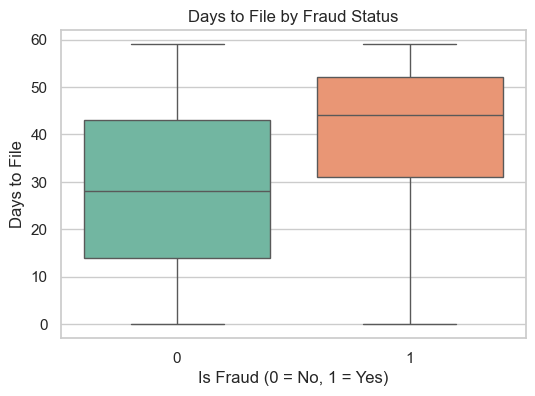

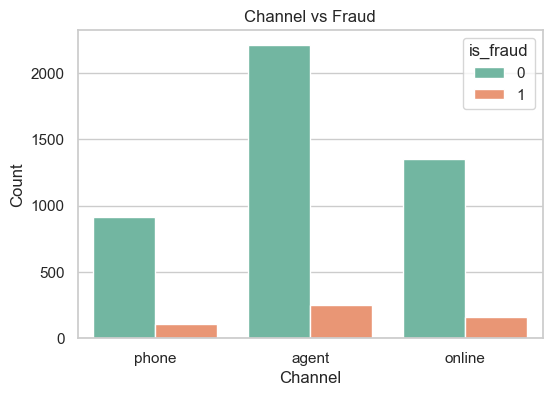

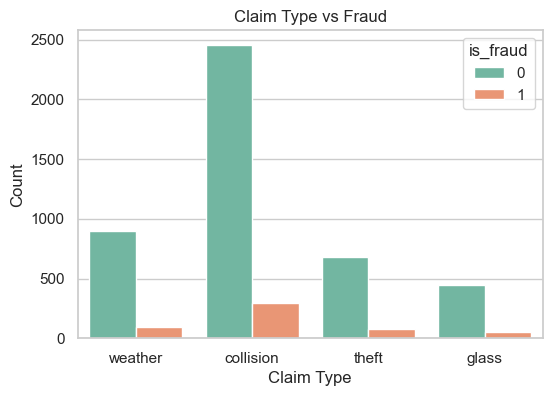

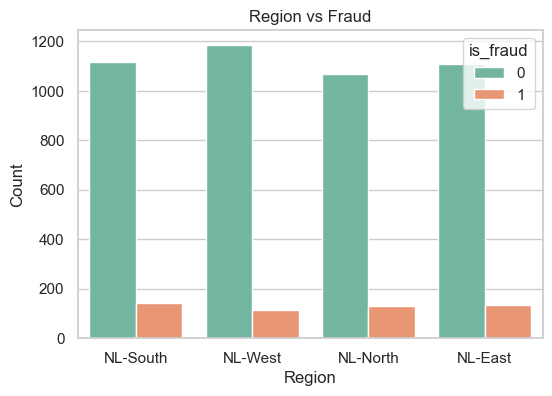

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set a style
sns.set(style="whitegrid")

# 1) Fraud vs non-fraud counts
plt.figure(figsize=(5,4))
sns.countplot(x="is_fraud", data=df, palette="Set2")
plt.title("Fraud vs Non-Fraud Claims")
plt.xlabel("Is Fraud (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.savefig("fraud_counts.png", dpi=300, bbox_inches="tight")
plt.show()

# 2) Distribution of claim amounts
plt.figure(figsize=(7,5))
sns.histplot(df, x="claim_amount", hue="is_fraud", bins=50, kde=True, palette="Set2")
plt.title("Claim Amount Distribution (Fraud vs Non-Fraud)")
plt.xlabel("Claim Amount (€)")
plt.ylabel("Count")
plt.savefig("claim_amount_hist.png", dpi=300, bbox_inches="tight")
plt.show()

# 3) Average days to file by fraud status
plt.figure(figsize=(6,4))
sns.boxplot(x="is_fraud", y="days_to_file", data=df, palette="Set2")
plt.title("Days to File by Fraud Status")
plt.xlabel("Is Fraud (0 = No, 1 = Yes)")
plt.ylabel("Days to File")
plt.savefig("days_to_file_hist.png", dpi=300, bbox_inches="tight")
plt.show()

# 4) Channel breakdown by fraud
plt.figure(figsize=(6,4))
sns.countplot(x="channel", hue="is_fraud", data=df, palette="Set2")
plt.title("Channel vs Fraud")
plt.xlabel("Channel")
plt.ylabel("Count")
plt.savefig("channel_bar.png", dpi=300, bbox_inches="tight")
plt.show()

# 5) Claim type breakdown by fraud
plt.figure(figsize=(6,4))
sns.countplot(x="claim_type", hue="is_fraud", data=df, palette="Set2")
plt.title("Claim Type vs Fraud")
plt.xlabel("Claim Type")
plt.ylabel("Count")
plt.savefig("claim_type_bar.png", dpi=300, bbox_inches="tight")
plt.show()

# 6) Region breakdown by fraud
plt.figure(figsize=(6,4))
sns.countplot(x="region", hue="is_fraud", data=df, palette="Set2")
plt.title("Region vs Fraud")
plt.xlabel("Region")
plt.ylabel("Count")
plt.savefig("region_bar.png", dpi=300, bbox_inches="tight")
plt.show()

ROC AUC — Logistic Regression: 0.898
ROC AUC — Random Forest     : 0.867

Chosen flag rate: 25.0%
LogReg threshold ≈ 0.108
RandForest threshold ≈ 0.128

--- Metrics @ threshold (Logistic Regression) ---
              precision    recall  f1-score   support

           0      0.972     0.814     0.886       896
           1      0.332     0.798     0.469       104

    accuracy                          0.812      1000
   macro avg      0.652     0.806     0.677      1000
weighted avg      0.905     0.812     0.842      1000


--- Metrics @ threshold (Random Forest) ---
              precision    recall  f1-score   support

           0      0.965     0.805     0.878       896
           1      0.308     0.750     0.437       104

    accuracy                          0.799      1000
   macro avg      0.637     0.777     0.657      1000
weighted avg      0.897     0.799     0.832      1000



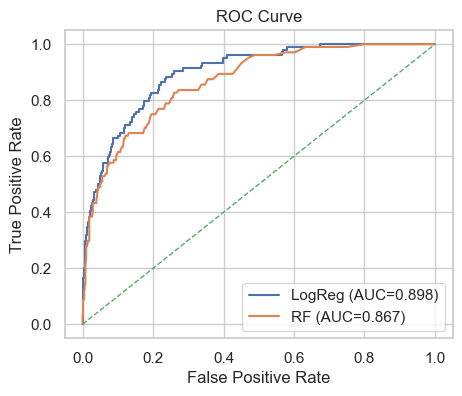

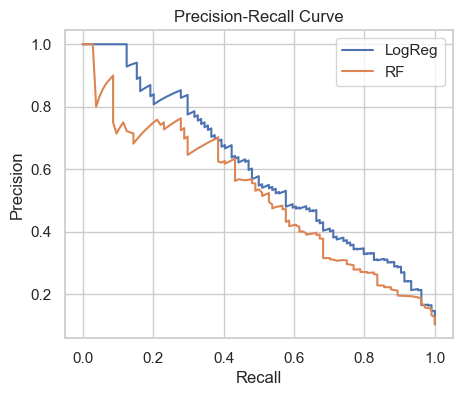


Top positive LR coefficients (risk↑):
claim_amount            1.362
days_to_file            1.032
has_prior_claims_1      0.472
vehicle_age_yrs         0.231
region_NL-South         0.101
region_NL-East          0.082
region_NL-North         0.072
channel_phone           0.051
claim_type_weather      0.040
claim_type_collision    0.034
dtype: float64

Top negative LR coefficients (risk↓):
channel_phone           0.051
claim_type_weather      0.040
claim_type_collision    0.034
channel_online          0.019
claim_type_glass        0.005
channel_agent          -0.069
claim_type_theft       -0.079
region_NL-West         -0.255
has_prior_claims_0     -0.472
policy_tenure_yrs      -0.582
dtype: float64

Top RF feature importances:
claim_amount            0.358
policy_tenure_yrs       0.164
days_to_file            0.162
vehicle_age_yrs         0.149
claim_type_collision    0.015
channel_agent           0.015
region_NL-South         0.015
region_NL-North         0.014
channel_online         

In [6]:
# --- Step 2: Pipeline & Models (Logistic Regression + Random Forest) ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    roc_auc_score, classification_report, roc_curve, precision_recall_curve
)

# 0) Load data (use existing df if present; else load from CSV)
try:
    df
except NameError:
    df = pd.read_csv("claims_dataset.csv")

# 1) Train / test split
y = df["is_fraud"].astype(int)
X = df.drop(columns=["is_fraud", "claim_id"])  # keep claim_id out of training

num_cols = ["claim_amount", "days_to_file", "policy_tenure_yrs", "vehicle_age_yrs"]
cat_cols = ["channel", "region", "claim_type", "has_prior_claims"]  # binary kept as categorical

X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=7
)

# 2) Preprocessing: scale numeric, one-hot encode categorical
pre = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols),
    ],
    remainder="drop",
    verbose_feature_names_out=False,
)

# 3) Models
logreg = Pipeline(steps=[
    ("pre", pre),
    ("clf", LogisticRegression(max_iter=2000, n_jobs=None)) 
])

rf = Pipeline(steps=[
    ("pre", pre),
    ("clf", RandomForestClassifier(
        n_estimators=400, random_state=7, n_jobs=-1, max_depth=None
    ))
])

# 4) Fit
logreg.fit(X_tr, y_tr)
rf.fit(X_tr, y_tr)

# 5) Predict probabilities
p_lr = logreg.predict_proba(X_te)[:, 1]
p_rf = rf.predict_proba(X_te)[:, 1]

# 6) AUC
auc_lr = roc_auc_score(y_te, p_lr)
auc_rf = roc_auc_score(y_te, p_rf)
print(f"ROC AUC — Logistic Regression: {auc_lr:0.3f}")
print(f"ROC AUC — Random Forest     : {auc_rf:0.3f}")

# 7) Select a threshold by target flag rate (investigator capacity proxy)
def predict_by_flag_rate(p, target_flag_rate=0.25):
    """
    Choose threshold so that ~target_flag_rate of cases are flagged.
    """
    thr = np.quantile(p, 1 - target_flag_rate)
    y_hat = (p >= thr).astype(int)
    return thr, y_hat

target_flag_rate = 0.25  # tune this to match investigator capacity
thr_lr, yhat_lr = predict_by_flag_rate(p_lr, target_flag_rate)
thr_rf, yhat_rf = predict_by_flag_rate(p_rf, target_flag_rate)

print(f"\nChosen flag rate: {target_flag_rate*100:.1f}%")
print(f"LogReg threshold ≈ {thr_lr:0.3f}")
print(f"RandForest threshold ≈ {thr_rf:0.3f}")

# 8) Metrics at the chosen threshold
print("\n--- Metrics @ threshold (Logistic Regression) ---")
print(classification_report(y_te, yhat_lr, digits=3))
print("\n--- Metrics @ threshold (Random Forest) ---")
print(classification_report(y_te, yhat_rf, digits=3))

# 9) ROC and Precision-Recall curves (matplotlib only)
fpr_lr, tpr_lr, _ = roc_curve(y_te, p_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_te, p_rf)
prec_lr, rec_lr, _ = precision_recall_curve(y_te, p_lr)
prec_rf, rec_rf, _ = precision_recall_curve(y_te, p_rf)

plt.figure(figsize=(5,4))
plt.plot(fpr_lr, tpr_lr, label=f"LogReg (AUC={auc_lr:.3f})")
plt.plot(fpr_rf, tpr_rf, label=f"RF (AUC={auc_rf:.3f})")
plt.plot([0,1], [0,1], linestyle="--", linewidth=1)
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate"); plt.title("ROC Curve"); plt.legend()
plt.savefig("roc_curve.png",dpi=300, bbox_inches="tight")
plt.show()

plt.figure(figsize=(5,4))
plt.plot(rec_lr, prec_lr, label="LogReg")
plt.plot(rec_rf, prec_rf, label="RF")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("Precision-Recall Curve"); plt.legend()
plt.savefig("pr_curve.png",dpi=300, bbox_inches="tight")
plt.show()

# 10) Simple feature importance views
# Helper to recover feature names after ColumnTransformer
def get_feature_names(preprocessor, num_cols, cat_cols):
    ohe = preprocessor.named_transformers_["cat"]
    cat_features = ohe.get_feature_names_out(cat_cols)
    return list(num_cols) + list(cat_features)

feature_names = get_feature_names(logreg.named_steps["pre"], num_cols, cat_cols)

# 10a) Logistic Regression coefficients (higher => more fraud risk)
coef_lr = logreg.named_steps["clf"].coef_[0]
lr_importance = pd.Series(coef_lr, index=feature_names).sort_values(ascending=False)
print("\nTop positive LR coefficients (risk↑):")
print(lr_importance.head(10).round(3))
print("\nTop negative LR coefficients (risk↓):")
print(lr_importance.tail(10).round(3))

# 10b) Random Forest feature importances (Gini)
rf_importances = rf.named_steps["clf"].feature_importances_
rf_importance = pd.Series(rf_importances, index=feature_names).sort_values(ascending=False)
print("\nTop RF feature importances:")
print(rf_importance.head(12).round(3))


In [11]:
import pandas as pd

# ===== Inputs (edit as needed) =====
total_claims   = 1000
fraud_cases    = 104          # fraud count in test set
flag_rate      = 0.25         # 25% investigated
precision_ai   = 0.332        # LogReg @ 25% flag
recall_ai      = 0.798        # LogReg @ 25% flag
investigators  = 50
days_per_claim = 5

# ===== Manual (no AI) =====
manual_investigated   = total_claims
manual_fraud_caught   = fraud_cases                 # check everything
manual_precision      = fraud_cases / total_claims
manual_inv_days       = manual_investigated * days_per_claim
manual_calendar_days  = manual_inv_days / investigators
manual_days_per_fraud = manual_inv_days / manual_fraud_caught

# ===== With AI =====
ai_investigated   = int(round(total_claims * flag_rate))
ai_fraud_caught   = int(round(recall_ai * fraud_cases))
ai_precision      = precision_ai
ai_inv_days       = ai_investigated * days_per_claim
ai_calendar_days  = ai_inv_days / investigators
ai_days_per_fraud = ai_inv_days / ai_fraud_caught

# ===== Build comparison table (formatted) =====
df = pd.DataFrame({
    "Metric": [
        "Claims investigated",
        "Investigator-days (5 days/claim)",
        "Calendar days @ 50 investigators",
        "Fraud cases in dataset",
        "Fraud caught (recall)",
        "Precision (fraud hit rate)",
        "Investigator-days per fraud caught",
    ],
    "Manual (No AI)": [
        f"{manual_investigated:,}",
        f"{manual_inv_days:,}",
        f"{manual_calendar_days:,.1f}",
        f"{fraud_cases:,}",
        f"{manual_fraud_caught:,} (100%)",
        f"{manual_precision:.2%}",
        f"{manual_days_per_fraud:,.1f}",
    ],
    "With AI (LogReg @ 25% flag)": [
        f"{ai_investigated:,}",
        f"{ai_inv_days:,}",
        f"{ai_calendar_days:,.1f}",
        f"{fraud_cases:,}",
        f"{ai_fraud_caught:,} ({recall_ai:.0%})",
        f"{ai_precision:.2%}",
        f"{ai_days_per_fraud:,.1f}",
    ],
    "Δ (Savings / Change)": [
        f"{manual_investigated - ai_investigated:,} (−{(1 - ai_investigated/manual_investigated):.0%})",
        f"{manual_inv_days - ai_inv_days:,} (−{(1 - ai_inv_days/manual_inv_days):.0%})",
        f"{manual_calendar_days - ai_calendar_days:,.1f} (−{(1 - ai_calendar_days/manual_calendar_days):.0%})",
        "—",
        f"{ai_fraud_caught - manual_fraud_caught:,}",
        f"{(ai_precision/manual_precision):.1f}× effectiveness",
        f"{ai_days_per_fraud - manual_days_per_fraud:,.1f}",
    ],
})

# Display
pd.set_option("display.max_colwidth", 100)
print(df.to_string(index=False))


                            Metric Manual (No AI) With AI (LogReg @ 25% flag) Δ (Savings / Change)
               Claims investigated          1,000                         250           750 (−75%)
  Investigator-days (5 days/claim)          5,000                       1,250         3,750 (−75%)
  Calendar days @ 50 investigators          100.0                        25.0          75.0 (−75%)
            Fraud cases in dataset            104                         104                    —
             Fraud caught (recall)     104 (100%)                    83 (80%)                  -21
        Precision (fraud hit rate)         10.40%                      33.20%   3.2× effectiveness
Investigator-days per fraud caught           48.1                        15.1                -33.0



--- Logistic Regression @ ~25.0% flag rate ---
Threshold: 0.108
Precision (PPV): 0.332
Recall (TPR)   : 0.798
F1-score       : 0.469
Confusion Matrix [[TN, FP],[FN, TP]]:
[[729 167]
 [ 21  83]]

--- Random Forest @ ~25.3% flag rate ---
Threshold: 0.128
Precision (PPV): 0.308
Recall (TPR)   : 0.750
F1-score       : 0.437
Confusion Matrix [[TN, FP],[FN, TP]]:
[[721 175]
 [ 26  78]]


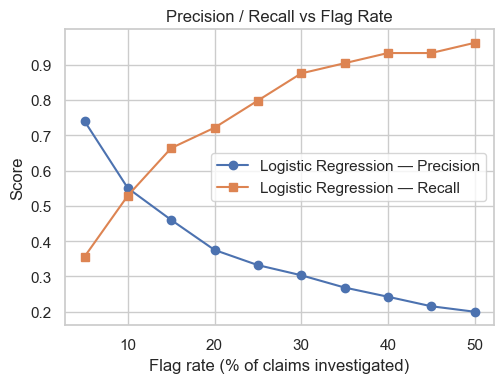

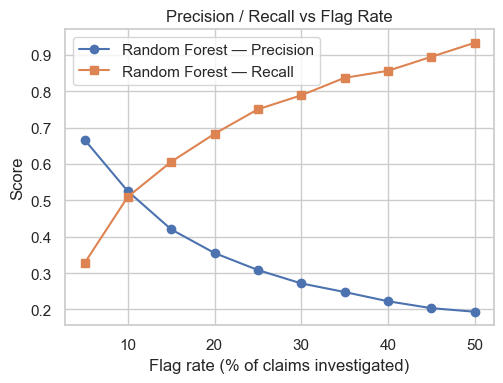

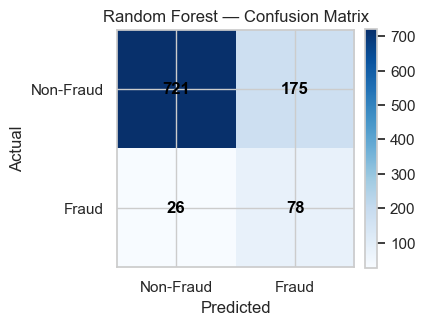

In [7]:
# --- Step 3: Thresholding & Business Framing ---
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Safety checks (will raise if Step 2 wasn't run)
assert 'y_te' in globals() and 'p_lr' in globals() and 'p_rf' in globals(), \
    "Run Step 2 first to get y_te, p_lr, and p_rf."

def evaluate_at_flag_rate(y_true, y_proba, flag_rate=0.25):
    """
    Choose a threshold so that approximately 'flag_rate' fraction of cases are flagged.
    Returns metrics + confusion matrix.
    """
    thr = np.quantile(y_proba, 1 - flag_rate)
    y_pred = (y_proba >= thr).astype(int)

    cm = confusion_matrix(y_true, y_pred, labels=[0,1])  # [[tn, fp],[fn, tp]]
    tn, fp, fn, tp = cm.ravel()

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall    = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    f1        = (2 * precision * recall / (precision + recall)) if (precision + recall) > 0 else 0.0

    return {
        "threshold": float(thr),
        "flagged": int(y_pred.sum()),
        "total": int(len(y_true)),
        "precision": float(precision),
        "recall": float(recall),
        "f1": float(f1),
        "cm": cm
    }

def print_report(name, res):
    rate = res["flagged"] / res["total"]
    tn, fp, fn, tp = res["cm"].ravel()
    print(f"\n--- {name} @ ~{rate*100:.1f}% flag rate ---")
    print(f"Threshold: {res['threshold']:.3f}")
    print(f"Precision (PPV): {res['precision']:.3f}")
    print(f"Recall (TPR)   : {res['recall']:.3f}")
    print(f"F1-score       : {res['f1']:.3f}")
    print(f"Confusion Matrix [[TN, FP],[FN, TP]]:\n{res['cm']}")

def plot_confusion_matrix(cm, title="Confusion Matrix"):
    import matplotlib.pyplot as plt
    import numpy as np
    
    tn, fp, fn, tp = cm.ravel()
    disp = np.array([[tn, fp],[fn, tp]])
    fig, ax = plt.subplots(figsize=(4.2,3.6))
    
    # Use a lighter colormap
    im = ax.imshow(disp, interpolation='nearest', cmap="Blues")
    
    ax.set_title(title)
    ax.set_xlabel('Predicted'); ax.set_ylabel('Actual')
    ax.set_xticks([0,1]); ax.set_yticks([0,1])
    ax.set_xticklabels(['Non-Fraud','Fraud'])
    ax.set_yticklabels(['Non-Fraud','Fraud'])
    
    # Annotate cells with numbers in black text
    for i in range(2):
        for j in range(2):
            ax.text(j, i, f"{disp[i,j]}", ha='center', va='center', color="black", fontsize=12, fontweight="bold")
    
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()
def sweep_flag_rates(y_true, y_proba, rates=np.linspace(0.05, 0.5, 10), label="Model"):
    precisions, recalls = [], []
    for r in rates:
        res = evaluate_at_flag_rate(y_true, y_proba, flag_rate=r)
        precisions.append(res["precision"])
        recalls.append(res["recall"])
    plt.figure(figsize=(5.2,4))
    plt.plot(rates*100, precisions, marker='o', label=f"{label} — Precision")
    plt.plot(rates*100, recalls,   marker='s', label=f"{label} — Recall")
    plt.xlabel("Flag rate (% of claims investigated)")
    plt.ylabel("Score")
    plt.title("Precision / Recall vs Flag Rate")
    plt.legend()
    plt.tight_layout()
    plt.savefig("flag.png",dpi=300, bbox_inches="tight")
    plt.show()

# === Choose your investigation capacity here ===
target_flag_rate = 0.25  # e.g., investigate top 25% riskiest claims

# Evaluate at chosen flag rate
res_lr = evaluate_at_flag_rate(y_te, p_lr, flag_rate=target_flag_rate)
res_rf = evaluate_at_flag_rate(y_te, p_rf, flag_rate=target_flag_rate)

# Print compact reports
print_report("Logistic Regression", res_lr)
print_report("Random Forest", res_rf)

# Plot PR vs Flag Rate curves (helps pick a sensible operating point)
rates = np.linspace(0.05, 0.5, 10)  # 5% to 50%
sweep_flag_rates(y_te, p_lr, rates, label="Logistic Regression")
sweep_flag_rates(y_te, p_rf, rates, label="Random Forest")

# Visualize confusion matrix at the chosen operating point for the stronger model
# (Pick whichever had higher AUC or better precision/recall)
plot_confusion_matrix(res_rf["cm"], title="Random Forest — Confusion Matrix")
